### H1N1 DataDrive

In [73]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt
from skimage import io
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense

## Import and Prepare Data 

In [74]:
# Read in the dataset
train_features = pd.read_csv("training_set_features.csv", sep=",")

In [75]:
train_features.head(5)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [76]:
test_features = pd.read_csv("test_set_features.csv",  sep=",")

### Merge Train / Test sets

In [77]:
df = pd.concat([train_features,test_features])
df.shape

(53415, 36)

### Data Preparation

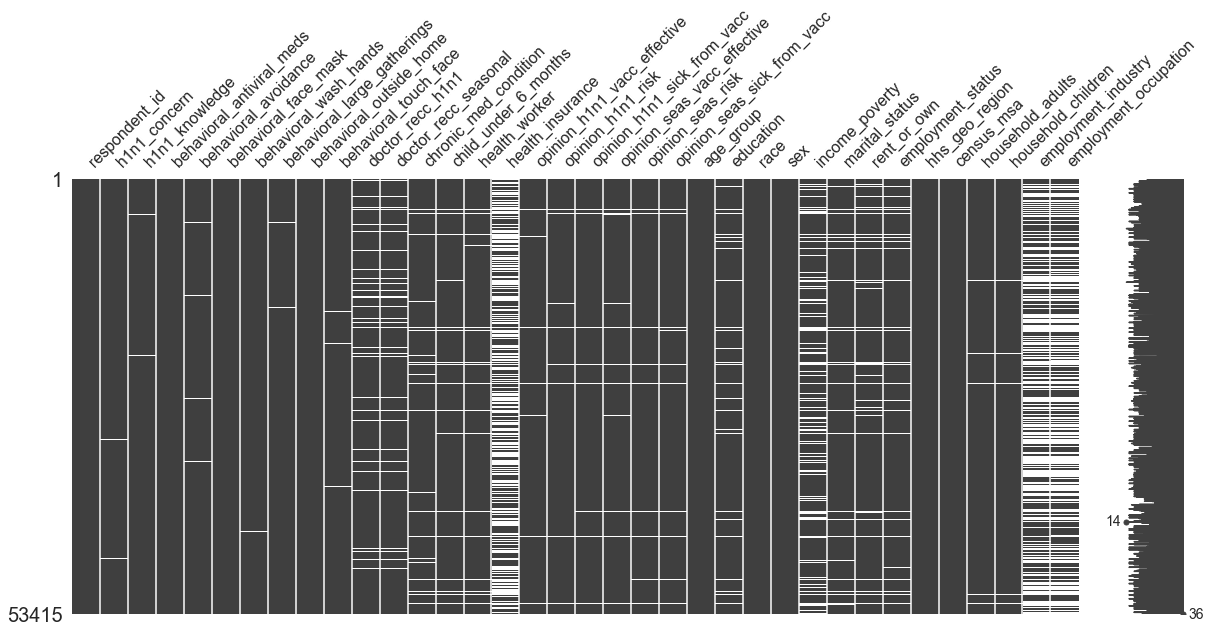

In [78]:
msno.matrix(df, figsize=(20,8))
plt.show()

In [79]:
null_cols = (df.isnull().sum()/len(df))
null_val = pd.DataFrame({'Null Ratio': null_cols})
null_val.drop(null_val[null_val['Null Ratio'] == 0].index, inplace=True)
sorted_null_val = null_val.sort_values('Null Ratio', ascending=False).head(15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 <a list of 7 Text yticklabel objects>)

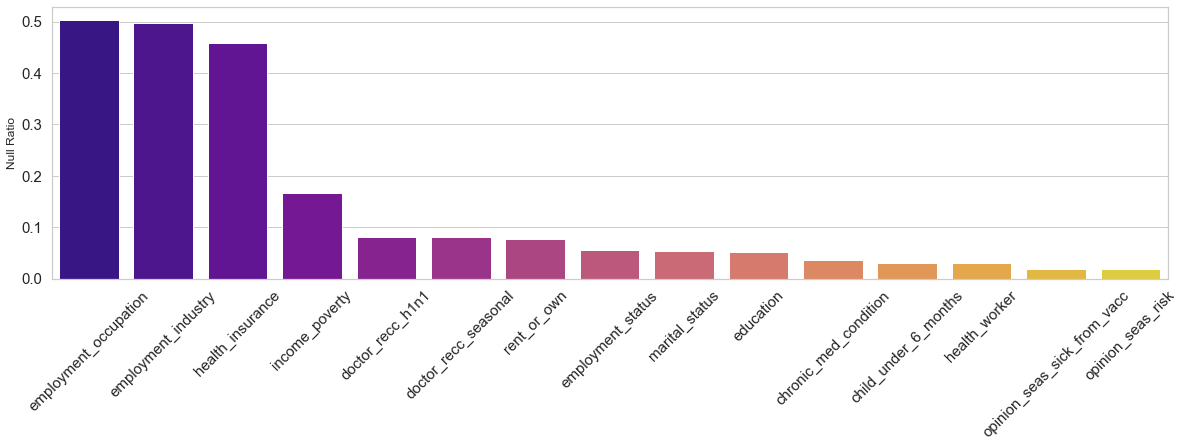

In [80]:
plt.subplots(figsize=(20,5))
sns.barplot(data=sorted_null_val, x=sorted_null_val.index, y='Null Ratio', palette='plasma')
plt.xticks(rotation=45, size=15)
plt.yticks(size=15)

Employment_occupation, employment_industry and health_insurance are by far the worst, but we have other null values as well.

In [81]:
train_labels = pd.read_csv("training_set_labels.csv", ",")
train_labels.head(5)

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


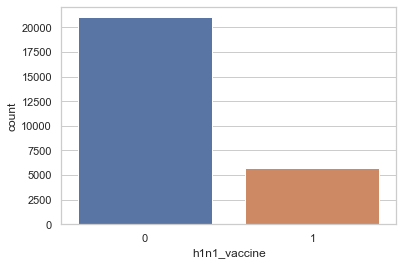

In [82]:
sns.countplot(x='h1n1_vaccine', data=train_labels)

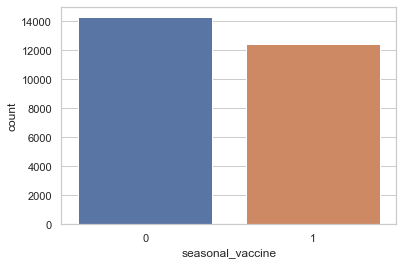

In [83]:
sns.countplot(x='seasonal_vaccine', data=train_labels)

From the labels data, seasonal vaccination is pretty common whereas for h1n1 it cannot be said so.
We then proceed to join the label with the rest of the set. We use an outer join so that all rows that have no label (test set) are then added as a null value (which will make it easy for us to separate them later on)

In [84]:
data = df.merge(train_labels, on='respondent_id', how='outer')

In [85]:
data.tail()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
53410,53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN,NaN,NaN
53411,53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov,NaN,NaN
53412,53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN,NaN,NaN
53413,53413,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,Own,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",1.0,0.0,NaN,NaN,NaN,NaN
53414,53414,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,Rent,Employed,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,xtkaffoo,NaN,NaN


In [86]:
data.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [87]:
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].astype('category')

In [89]:
train_features.shape

(26707, 36)

In [90]:
train_features.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [91]:
df_train = pd.merge(train_features, train_labels, how="left", left_on=["respondent_id"], right_on=["respondent_id"])
df_train.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


Look at how many unique values has each field (including NaNs)

In [93]:
def unique_categories(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(column, len(df[column].unique()))

def all_uniques(df):
    for column in df.columns:
        print(column, len(df[column].unique()))

In [94]:
all_uniques(df_train)

respondent_id 26707
h1n1_concern 5
h1n1_knowledge 4
behavioral_antiviral_meds 3
behavioral_avoidance 3
behavioral_face_mask 3
behavioral_wash_hands 3
behavioral_large_gatherings 3
behavioral_outside_home 3
behavioral_touch_face 3
doctor_recc_h1n1 3
doctor_recc_seasonal 3
chronic_med_condition 3
child_under_6_months 3
health_worker 3
health_insurance 3
opinion_h1n1_vacc_effective 6
opinion_h1n1_risk 6
opinion_h1n1_sick_from_vacc 6
opinion_seas_vacc_effective 6
opinion_seas_risk 6
opinion_seas_sick_from_vacc 6
age_group 5
education 5
race 4
sex 2
income_poverty 4
marital_status 3
rent_or_own 3
employment_status 4
hhs_geo_region 10
census_msa 3
household_adults 5
household_children 5
employment_industry 22
employment_occupation 24
h1n1_vaccine 2
seasonal_vaccine 2


In [95]:
drop_cols = ["health_insurance", "employment_industry", "employment_occupation"]

In [96]:
data.drop(drop_cols, inplace = True, axis = 1)

In [108]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
le = LabelEncoder()
# Encode a categorical feature
data['census_msa_cat'] = le.fit_transform(data['census_msa'])
# remove the original column
data.drop(["census_msa"], inplace = True, axis = 1)

In [98]:
#data.loc[df_train["census_msa"] == "Non-MSA", "census_msa"] = 0
#data.loc[df_train["census_msa"] == "MSA, Not Principle  City", "census_msa"] = 1
#data.loc[df_train["census_msa"] == "MSA, Principle City", "census_msa"] = 2

In [99]:
data.loc[data["household_children"]>0, "household_children"] = 1

In [100]:
data.loc[data["household_adults"]>0, "household_adults"] = 1

In [109]:
# Create a LabelEncoder object
le = LabelEncoder()
# Encode a categorical feature
data['hhs_geo_region_cat'] = le.fit_transform(data['hhs_geo_region'])
# remove the original column
data.drop(["hhs_geo_region"], inplace = True, axis = 1)

In [146]:
for column in data.columns.difference(["h1n1_vaccine","seasonal_vaccine"]):
    data[column].fillna(data[column].mode()[0], inplace=True)

In [150]:
# Create a LabelEncoder object
le = LabelEncoder()
# Encode a categorical feature
data['employment_status_cat'] = le.fit_transform(data['employment_status'])
# remove the original column
data.drop(["employment_status"], inplace = True, axis = 1)

In [160]:
# Encode a categorical feature
data['rent_or_own_cat'] = pd.get_dummies(data["rent_or_own"],drop_first=True)
# remove the original column
data.drop(["rent_or_own"], inplace = True, axis = 1)

In [164]:
# Encode a categorical feature
data['marital_status_cat'] = pd.get_dummies(data["marital_status"],drop_first=True)
# remove the original column
data.drop(["marital_status"], inplace = True, axis = 1)

In [ ]:
# Encode a categorical feature
data['income_poverty_cat'] = pd.get_dummies(data["income_poverty"],drop_first=True)
# remove the original column
data.drop(["income_poverty"], inplace = True, axis = 1)

In [171]:
data = pd.get_dummies(data, columns=['income_poverty',"age_group","education","race","sex"], drop_first=True)

In [176]:
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,1,0,0,0,0,1,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,1
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1,0,0,0,0,1,0,0,1,0


In [18]:
# Instantiate model
model = Sequential()
# Add input and hidden layers
model.add(Dense(2, input_shape=(1,)))
# Add an output layer for the 3 classes and sigmoid activation
model.add(Dense(3, activation='sigmoid'))

In [19]:
# Compile the model with binary crossentropy
model.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
# Train your model, recall validation_split
model.fit(train_features, train_labels,
epochs=100,
validation_split=0.2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [21]:
import tensorflow.keras.backend as K


In [23]:
X_train = K.constant(train_features)
y_train = K.constant(train_labels)

ValueError: could not convert string to float: 'MSA, Principle City'